## Pokemon Generator Using VAEs


In [30]:
from os import listdir
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.utils as utils
import requests
import pandas as pd
from tqdm import tqdm
import gc
import json


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0


In [4]:
# scrape types from internet
def getType(name):
    path = f"https://pokeapi.co/api/v2/pokemon/{name}"
    try:
        response = requests.get(path)
        response.raise_for_status()  # Raise exception for 4XX and 5XX status codes
        types = response.json()['types']
        if len(types) == 1:
            t1 = types[0]['type']['name']
            return t1, t1
        return types[0]['type']['name'], types[1]['type']['name']
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return 'N/A', 'N/A'

In [5]:
#import types into dictionary
df = pd.read_csv('scrape/pokemon.csv')
df['Name'] = df['Name'].str.capitalize()
df.set_index('Name',inplace=True)
TYPES = df.to_dict(orient='index')

In [6]:
df = pd.read_csv('scrape/types.csv')
typelist = df['type'].tolist()
typedict = {typelist[i]: i for i in range(len(typelist))}
print(typedict)

type_label = torch.Tensor(1,1) #torch.from_numpy(np.array(5,dtype="int"))
type_choice = typelist[np.random.randint(0,18,)]

print(f"type: {type_choice}")

type_label[0] = typedict[type_choice]
one_hot = F.one_hot(type_label.squeeze().long(), num_classes=18)

print(type_label)
print(one_hot)

one_hot = one_hot[None,:,None,None].repeat(64,1,256,256)

print(one_hot)

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
type: poison
tensor([[13.]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0,

In [7]:
def create_ohe(type): #one hot encoded vector for desired type !!MAKE THIS WORK FOR BATCHES LATER ON, RIGHT NOW ONLY WORKS FOR INDIVIDUAL IMAGES!!
    type_value = typedict[type]
    label = torch.Tensor(1,1)
    label[0] = type_value
    one_hot = F.one_hot(label.squeeze().long(), num_classes=18)
    return one_hot

In [8]:
create_ohe("water")

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [9]:
def create_ohe_batch(type): #one hot encoded vector for desired type !!MAKE THIS WORK FOR BATCHES LATER ON, RIGHT NOW ONLY WORKS FOR INDIVIDUAL IMAGES!!
    type_list = []
    for t in type:
        # print(t)
        # print(typedict[t])
        type_list.append(typedict[t])
    one_hot = F.one_hot(torch.LongTensor(np.array(type_list)).squeeze().long(), num_classes=18)
    return one_hot

In [10]:
create_ohe_batch(["water", "grass", "fire"])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
#store all images in dataset
def load_pokeset():
  data_dir = 'pokemonImages'
  dataset = []
  name = []
  i = 0
  for path in tqdm(listdir(data_dir)):
    for img in listdir(data_dir + '/' + path):
        im = np.asarray(Image.open(data_dir + '/' + path + '/' + img).resize((256,256))).transpose(2,0,1)
        dataset.append(im)
        name.append(str(path).lower().capitalize())
        i+=1
  print(i)
  return np.array(dataset), np.array(name)

In [12]:
dataset, name = load_pokeset()
# print(dataset.shape)

100%|██████████| 898/898 [00:04<00:00, 184.28it/s]


2500


In [13]:
class PokemonDataset(Dataset):
    def __init__(self, images, names) -> None:
        super().__init__()

        self.images = images
        self.names = names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        sample = {'pokemon':torch.from_numpy(self.images[index])/255, 'name' : self.names[index], 'type' : TYPES[self.names[index]]}
        return sample

In [14]:
pokeset = PokemonDataset(images=dataset, names=name)
pokeloader = DataLoader(pokeset, batch_size=64, shuffle= True, num_workers=0)
print(f"batches: {len(pokeloader)}")

batches: 40


In [15]:
def show_pokemon_batch(sample_batched): #https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    pokemon_batch = sample_batched['pokemon']
    grid = utils.make_grid(pokemon_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

0 torch.Size([64, 3, 256, 256])


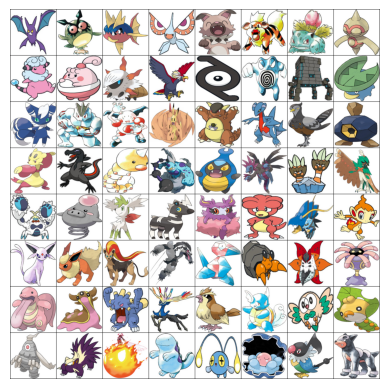

1 torch.Size([64, 3, 256, 256])


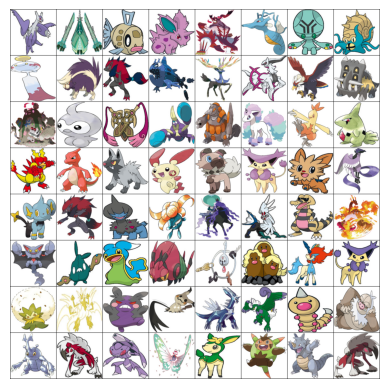

2 torch.Size([64, 3, 256, 256])


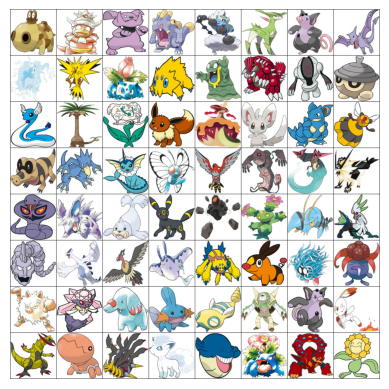

3 torch.Size([64, 3, 256, 256])


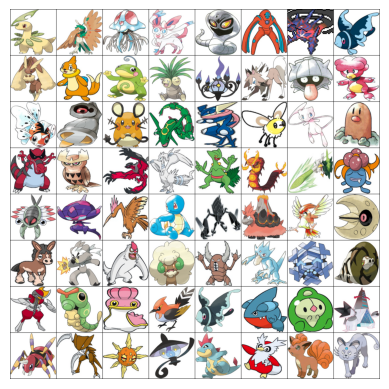

In [16]:
for i_batch, sample_batched in enumerate(pokeloader):
    print(i_batch, sample_batched['pokemon'].size())
    sample_img = sample_batched
    plt.figure()
    show_pokemon_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break

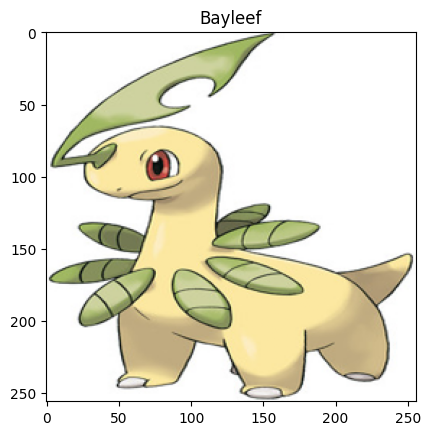

torch.Size([3, 256, 256])
type1: grass
type2: grass


In [17]:
#sample_img = next(iter(pokeloader))
plt.title(sample_img['name'][0])
plt.imshow(sample_img['pokemon'][0].permute(1,2,0).detach().numpy())
plt.show()
print(sample_img['pokemon'][0].shape)
print(f"type1: {sample_img['type']['type1'][0]}")
print(f"type2: {sample_img['type']['type2'][0]}")

In [18]:
class Encoder(nn.Module):
    def __init__(self,input_shape, z_dim):
        super().__init__()
        self.d,h,w = input_shape
        self.conv1 = nn.Conv2d(3, 20, kernel_size= 2, stride= 2)#128
        self.conv2 = nn.Conv2d(20,50, kernel_size= 2, stride= 2)#64
        self.conv3 = nn.Conv2d(50,75, kernel_size= 2, stride= 2)#32
        self.conv4 = nn.Conv2d(75,100, kernel_size= 2, stride= 2)#16

        self.c_bn1 = nn.BatchNorm2d(20)
        self.c_bn2 = nn.BatchNorm2d(50)
        self.c_bn3 = nn.BatchNorm2d(75)
        self.c_bn4 = nn.BatchNorm2d(100)

        self.mu = nn.Linear(100*16*16, z_dim)
        self.sigma = nn.Linear(100*16*16, z_dim)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.view(-1, 3, 256,256).float()

        out = self.relu(self.c_bn1(self.conv1(x)))
        out = self.relu(self.c_bn2(self.conv2(out)))
        out = self.relu(self.c_bn3(self.conv3(out)))
        out = self.relu(self.c_bn4(self.conv4(out)))

        mu = self.mu(self.flatten(out))
        sigma = self.sigma(self.flatten(out))

        return mu,sigma

In [19]:
class Decoder(nn.Module):
    def __init__(self,input_shape, output_shape):
        super().__init__()
        d,_,_ = output_shape
        self.input_shape = input_shape
        # self.convT0 = nn.ConvTranspose2d(input_shape[1],...., kernel_size=16, stride= 1)
        self.lin = nn.Linear(input_shape,100*16*16)

        self.convT1 = nn.ConvTranspose2d(100,75, kernel_size= 2, stride= 2)#32
        self.convT2 = nn.ConvTranspose2d(75,50, kernel_size= 2, stride= 2)#64
        self.convT3 = nn.ConvTranspose2d(50,20, kernel_size= 2, stride= 2)#128
        self.convT4 = nn.ConvTranspose2d(20,3, kernel_size= 2, stride= 2)#256

        self.cT_bn1 = nn.BatchNorm2d(75)
        self.cT_bn2 = nn.BatchNorm2d(50)
        self.cT_bn3 = nn.BatchNorm2d(20)
        self.cT_bn4 = nn.BatchNorm2d(3)

        self.relu = nn.LeakyReLU()

    def forward(self, z):
        out = self.relu(self.lin(z))
        out = out.view(-1,100,16,16)
        out = self.relu(self.cT_bn1(self.convT1(out)))
        out = self.relu(self.cT_bn2(self.convT2(out)))
        out = self.relu(self.cT_bn3(self.convT3(out)))
        out = self.convT4(out)

        return (nn.Tanh()(out) + 1 )/2

In [20]:
#VAE
class VAE(nn.Module):
    def __init__(self,im_shape, z_dim): #input_shape = (3,256,256), z_dim is number of features for each mu and sigma vector
        super().__init__()

        self.encoder = Encoder(im_shape, z_dim)
        self.decoder = Decoder(z_dim, im_shape)

    #one model, cluster latent space and hope clusters are representative types which we sample from
    
    def reparam(self,mean,std):
        q = torch.distributions.Normal(mean,std)
        return q.rsample()

    def forward(self,input):
        mean,sigma = self.encoder(input)
        #calculate latent vector z = mu + sigma*(sample from normal distribution)
        #from my understanding, we get mu and sigma for every pokemon (eventually want to sample from a cluster that have same) and use
        if torch.isnan(mean).any():
            print(self.encoder.mu.weight)
            print(f"mean: {mean}")
        std = torch.exp(sigma/2)
        
        z = self.reparam(mean,std)
        
        if torch.isnan(z).any():
            print(f"z: {z}")
        reconstruct = self.decoder(z)
        return reconstruct, mean, std, z


In [21]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_normal_(m.weight)
        m.weight.requires_grad = True
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.weight.requires_grad = True
        m.bias.requires_grad= True
    

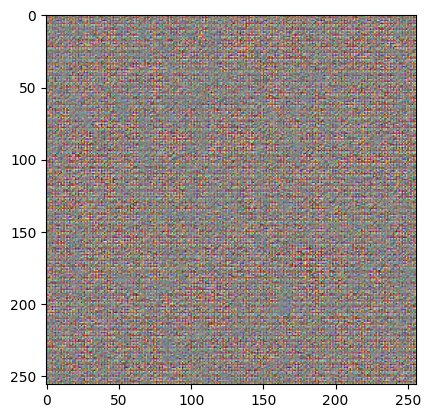

torch.Size([1, 3, 256, 256])
torch.Size([1, 50])


In [22]:
#test case
img_dim = (3,256,256)
vae = VAE(img_dim,50)
vae.apply(weights_init)
img = sample_img['pokemon'][0]
test_output,mu,sigma,z = vae(img)
plt.imshow(test_output[0].permute(1,2,0).detach().numpy())
plt.show()

print(test_output.shape)
# print(mu)
# print(sigma)
print(z.shape)


In [23]:
#VAE training phase
def VAE_train(vae_model, loss_fn, optimizer, train_data, n_epochs, update_interval):
    losses = []
    
    for epoch in range(n_epochs):
        for i, sample in enumerate(tqdm(train_data)):
            pkmn_img, type = sample['pokemon'], sample['type'] #image, dictionary key-value tuple-ish
            #print(pkmn_img.shape)
            optimizer.zero_grad()
            output, mu, sigma, z = vae_model(pkmn_img.to(device))

            # torch.concatenate((pkmn_img,typedict[type['type1']])) #TODO: likely wrong -> three channels

            reconstruction_loss = loss_fn(output.cpu(),pkmn_img.cpu())
            kl_loss = torch.sum(-0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp(), dim=1), dim=0)
            loss = reconstruction_loss + kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae_model.parameters(), 1)
            optimizer.step()

            if i % update_interval == 0:
                losses.append(loss.cpu().detach())
                
            del pkmn_img
            torch.cuda.empty_cache()
            gc.collect()
            
        print(f"epoch: {epoch}, loss: {loss}")
    return vae_model.cpu(), losses

In [24]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0


In [ ]:
import random

lrs = [1e-5, 2e-4]
bs = [32,50,64]
#ui = [21, 23]
eps = [100,250]
ms = [100,1000]
#mse, bce, ce
#bestParams = {'lr', 'bs', 'ui', 'ep', 'ms'}
bestLr = 0
bestBs = 0
bestUi = 0
bestEp = 0
bestMs = 0
bestLoss = float('inf')
inputSize = (3,256,256)

for i in range(15):
    testLr = random.uniform(lrs[0], lrs[1])
    testBs = random.choice(bs)
    testUi = 10
    testEp = random.randint(eps[0], eps[1])
    testMs = random.randint(ms[0], ms[1])
    
    train_data = DataLoader(pokeset, batch_size=64, shuffle= True, num_workers=0)

    new_model = VAE(inputSize, testMs).to(device)
    new_model.apply(weights_init)
    
    loss_function = nn.MSELoss(reduction="sum")
    optimizer = torch.optim.Adam(new_model.parameters(), lr=testLr)

    testModel, testLosses = VAE_train(new_model, loss_function, optimizer, train_data, testEp, testUi)

    testLoss = np.sum(testLosses)/len(pokeloader)

    if(testLoss < bestLoss):
        bestLr = testLr
        bestBs = testBs
        bestUi = testUi
        bestEp = testEp
        bestMs = testMs
        bestLoss = testLoss
        bestLosses = testLosses
        print("Loss:", bestLoss)
        print("lr:", + bestLr, " batchsize:", + bestBs, " update_interval:", + bestUi, " bestEp:", + bestEp, " bestMs:", testMs)
        print(bestLoss)
        plt.plot(np.arange(len(bestLosses)) * bestBs * bestUi, bestLosses)
        plt.title("training curve")
        plt.xlabel("number of images trained on")
        plt.ylabel("Reconstruction loss")
        plt.show()

 80%|████████  | 32/40 [00:10<00:01,  4.87it/s]

In [25]:
print("lr:", + bestLr, " batchsize:", + bestBs, " update_interval:", + bestUi, " bestEp:", + bestEp, " bestMs:", testMs)
print(bestLoss)
plt.plot(np.arange(len(bestLosses)) * bestBs * bestUi, bestLosses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.show()

NameError: name 'bestLr' is not defined

In [468]:
#lr = 0.0002712247306780326
lr = 6.526816475478975e-5
batch_size = 64
update_interval = 10
n_epochs = 100
moment_size = 703       

pokeloader = DataLoader(pokeset, batch_size=batch_size, shuffle= True, num_workers=0)

new_model = VAE(img_dim, moment_size).to(device)
new_model.apply(weights_init)

loss_function = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(new_model.parameters(), lr=lr)

trained_model, losses = VAE_train(new_model, loss_function, optimizer, pokeloader, n_epochs, update_interval)

100%|██████████| 40/40 [00:14<00:00,  2.74it/s]


epoch: 0, loss: 141694.234375


100%|██████████| 40/40 [00:11<00:00,  3.59it/s]


epoch: 1, loss: 120041.625


100%|██████████| 40/40 [00:11<00:00,  3.59it/s]


epoch: 2, loss: 128999.703125


100%|██████████| 40/40 [00:10<00:00,  3.66it/s]


epoch: 3, loss: 102916.4609375


100%|██████████| 40/40 [00:10<00:00,  3.69it/s]


epoch: 4, loss: 121686.5390625


100%|██████████| 40/40 [00:11<00:00,  3.58it/s]


epoch: 5, loss: 117253.078125


100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


epoch: 6, loss: 88000.609375


100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


epoch: 7, loss: 81098.0390625


100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


epoch: 8, loss: 91738.265625


100%|██████████| 40/40 [00:10<00:00,  3.67it/s]


epoch: 9, loss: 69276.8671875


100%|██████████| 40/40 [00:10<00:00,  3.68it/s]


epoch: 10, loss: 79011.1171875


100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


epoch: 11, loss: 71179.6015625


100%|██████████| 40/40 [00:10<00:00,  3.68it/s]


epoch: 12, loss: 58402.5390625


100%|██████████| 40/40 [00:10<00:00,  3.68it/s]


epoch: 13, loss: 73748.1328125


100%|██████████| 40/40 [00:10<00:00,  3.69it/s]


epoch: 14, loss: 68176.046875


100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


epoch: 15, loss: 68344.53125


 10%|█         | 4/40 [00:01<00:11,  3.11it/s]


KeyboardInterrupt: 

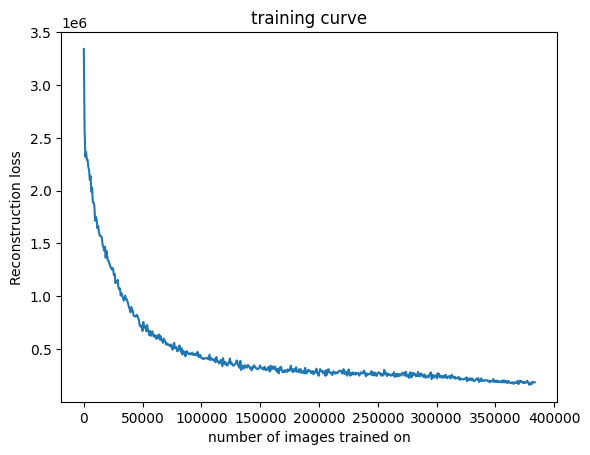

In [ ]:
plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.show()

In [46]:
loaded_model = VAE(img_dim, 100)

In [ ]:
#save model
torch.save(loaded_model.state_dict(), "prev_model.pth")

In [47]:
#load previously found model
loaded_model.load_state_dict(torch.load("prev_model.pth"))

<All keys matched successfully>

In [24]:
pkmn_batch = np.random.randint(0,63)

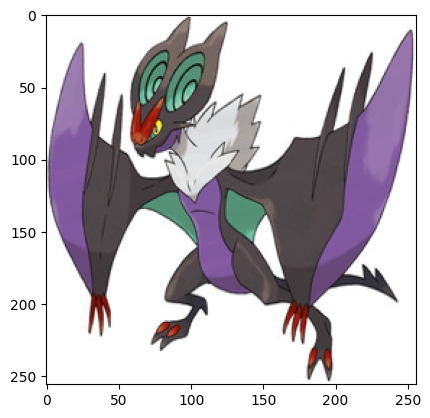

(256, 256, 3)


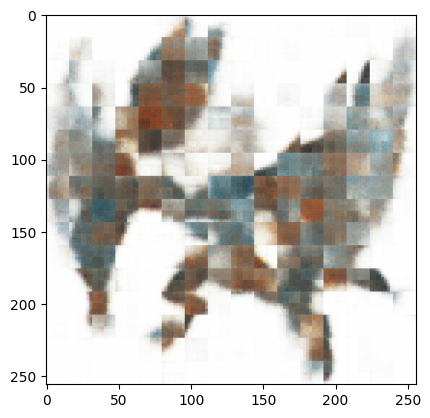

In [48]:
#run the saved model
load_output, _, _ , _= loaded_model(sample_img['pokemon'][pkmn_batch])
plt.imshow(sample_img['pokemon'][pkmn_batch].permute(1,2,0).detach().numpy())
plt.show()
gen = load_output[0].permute(1,2,0).detach().numpy()
# gen[:,:,1] = np.zeros_like(gen[:,:,1])
# gen[:,:,2] = np.zeros_like(gen[:,:,2])
plt.imshow(gen)
print(load_output[0].permute(1,2,0).detach().numpy().shape)
plt.show()

In [41]:
plt.imshow(gen)
plt.savefig("outputs/progress/teddiursa")

In [34]:
#load previously found model
trained_model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [83]:
#save model
torch.save(trained_model.state_dict(), "best.pth")

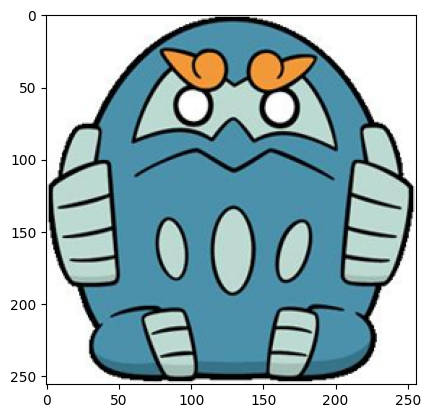

(256, 256, 3)


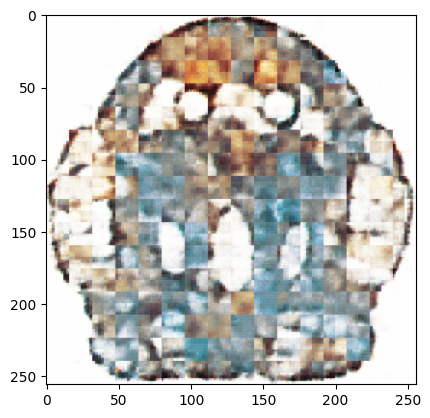

In [35]:
#run the newly trained model
trained_output, _, _ , _= trained_model(sample_img['pokemon'][pkmn_batch])
plt.imshow(sample_img['pokemon'][pkmn_batch].permute(1,2,0).detach().numpy())
plt.show()
gen = trained_output[0].permute(1,2,0).detach().numpy()
# gen[:,:,1] = np.zeros_like(gen[:,:,1])
# gen[:,:,2] = np.zeros_like(gen[:,:,2])
plt.imshow(gen)
print(trained_output[0].permute(1,2,0).detach().numpy().shape)
plt.show()

In [170]:
plt.imshow(gen)
plt.savefig("outputs/progress/smeargle_good")

(256, 256, 3)


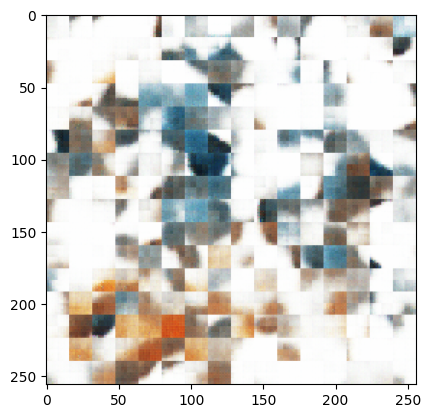

In [37]:

z = torch.randn((100,))
decode_out = loaded_model.decoder(z)
plt.imshow(decode_out[0].permute(1,2,0).detach().numpy())
print(decode_out[0].permute(1,2,0).detach().numpy().shape)
plt.show()

703
(256, 256, 3)


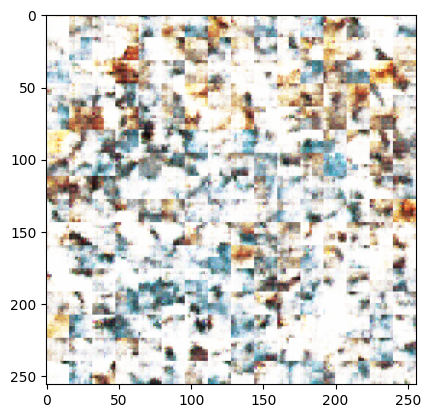

In [36]:
#completely randomly generated image from trained decode
print(moment_size)
z = torch.randn((703,))
decode_out = trained_model.decoder(z)
plt.imshow(decode_out[0].permute(1,2,0).detach().numpy())
print(decode_out[0].permute(1,2,0).detach().numpy().shape)
plt.show()

In [129]:
plt.imshow(decode_out[0].permute(1,2,0).detach().numpy())
plt.savefig("outputs/straight_noise/rand")

In [25]:
class cEncoder(nn.Module):
    def __init__(self,input_shape, z_dim):
        super().__init__()
        d,h,w = input_shape
        self.conv1 = nn.Conv2d(3, 20, kernel_size= 2, stride= 2)#128
        self.conv2 = nn.Conv2d(20,50, kernel_size= 2, stride= 2)#64
        self.conv3 = nn.Conv2d(50,75, kernel_size= 2, stride= 2)#32
        self.conv4 = nn.Conv2d(75,100, kernel_size= 2, stride= 2)#16

        self.c_bn1 = nn.BatchNorm2d(20)
        self.c_bn2 = nn.BatchNorm2d(50)
        self.c_bn3 = nn.BatchNorm2d(75)
        self.c_bn4 = nn.BatchNorm2d(100)

        self.mu = nn.Linear(100*16*16, z_dim)
        self.sigma = nn.Linear(100*16*16, z_dim)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.view(-1, 3, 256,256).float()

        out = self.relu(self.c_bn1(self.conv1(x)))
        out = self.relu(self.c_bn2(self.conv2(out)))
        out = self.relu(self.c_bn3(self.conv3(out)))
        out = self.relu(self.c_bn4(self.conv4(out)))

        mu = self.mu(self.flatten(out))
        sigma = self.sigma(self.flatten(out))

        return mu,sigma

In [26]:
class cDecoder(nn.Module):
    def __init__(self,input_shape, output_shape):
        super().__init__()
        d,_,_ = output_shape
        self.input_shape = input_shape
        # self.convT0 = nn.ConvTranspose2d(input_shape[1],...., kernel_size=16, stride= 1)
        self.lin = nn.Linear(input_shape,100*16*16)

        self.convT1 = nn.ConvTranspose2d(100,75, kernel_size= 2, stride= 2)#32
        self.convT2 = nn.ConvTranspose2d(75,50, kernel_size= 2, stride= 2)#64
        self.convT3 = nn.ConvTranspose2d(50,20, kernel_size= 2, stride= 2)#128
        self.convT4 = nn.ConvTranspose2d(20,3, kernel_size= 2, stride= 2)#256

        self.cT_bn1 = nn.BatchNorm2d(75)
        self.cT_bn2 = nn.BatchNorm2d(50)
        self.cT_bn3 = nn.BatchNorm2d(20)

        self.relu = nn.LeakyReLU()

    def forward(self, z):
        out = self.relu(self.lin(z))
        out = out.view(-1,100,16,16)
        out = self.relu(self.cT_bn1(self.convT1(out)))
        out = self.relu(self.cT_bn2(self.convT2(out)))
        out = self.relu(self.cT_bn3(self.convT3(out)))
        out = self.convT4(out)

        return (nn.Tanh()(out) + 1 )/2

Now with the actual CVAE stuff and labeling

In [27]:
#cVAE
class CVAE(nn.Module):
    def __init__(self,im_shape, z_dim): #input_shape = (3,256,256), z_dim is number of features for each mu and sigma vector
        super().__init__()
        self.z_dim = z_dim
        self.encoder = cEncoder(im_shape, z_dim)
        self.decoder = cDecoder(z_dim, im_shape)

    #one model, cluster latent space and hope clusters are representative types which we sample from
    
    def reparam(self,mean,std):
        q = torch.distributions.Normal(mean,std)
        return q.rsample()

    def forward(self,input):
        
        mean,sigma = self.encoder(input)
        
        if torch.isnan(mean).any():
            print(self.encoder.mu.weight)
            print(f"mean: {mean}")

        std = torch.exp(sigma/2)
       
        z = self.reparam(mean,std)
    
        reconstruct = self.decoder(z)
        return reconstruct, mean, std, z


In [28]:
#cVAE training phase
def CVAE_train(vae_model, loss_fn, optimizer, train_data, n_epochs, update_interval):
    losses = []
    
    for epoch in range(n_epochs):
        for i, sample in enumerate(tqdm(train_data)):
            pkmn_img = sample['pokemon']#image, dictionary key-value tuple-ish
           
            # label = type["type1"] #label of each iamge by primary pokemon typing
            # print(label)
            optimizer.zero_grad()
            output, mu, sigma, z = vae_model(pkmn_img.to(device))

            reconstruction_loss = loss_fn(output.cpu(),pkmn_img.cpu())
            kl_loss = torch.sum(-0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp(), dim=1), dim=0)
            
            loss = reconstruction_loss + 10*kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae_model.parameters(), 1)

            optimizer.step()

            if i % update_interval == 0:
                losses.append(loss.cpu().detach())
            
            del pkmn_img
            torch.cuda.empty_cache()
            gc.collect()
            
        print(f"epoch: {epoch}, loss: {loss}")
    return vae_model.cpu(), losses

In [302]:
lr = 6.526816475478975e-5
batch_size = 64
update_interval = 10
n_epochs = 100
moment_size = 638     #grey zone: 175 to like 200 ish

pokeloader = DataLoader(pokeset, batch_size=batch_size, shuffle= True, num_workers=0)

new_model = CVAE(img_dim, moment_size).to(device)
new_model.apply(weights_init)

loss_function = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(new_model.parameters(), lr=lr)

trained_cVAE, cVAElosses = CVAE_train(new_model, loss_function, optimizer, pokeloader, n_epochs, update_interval)

100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


epoch: 0, loss: 133462.578125


100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


epoch: 1, loss: 119580.1640625


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 2, loss: 134589.6875


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 3, loss: 113133.2109375


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


epoch: 4, loss: 113334.7890625


100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


epoch: 5, loss: 110072.8125


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 6, loss: 103340.34375


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 7, loss: 96670.515625


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 8, loss: 83884.6953125


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 9, loss: 87814.0


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 10, loss: 65712.1484375


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 11, loss: 79225.5


100%|██████████| 40/40 [00:10<00:00,  3.91it/s]


epoch: 12, loss: 67704.6484375


100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


epoch: 13, loss: 62551.96875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 14, loss: 56423.5078125


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 15, loss: 80936.1875


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 16, loss: 53548.51953125


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 17, loss: 57103.6953125


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 18, loss: 47728.6171875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 19, loss: 49067.91796875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 20, loss: 41257.19140625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 21, loss: 43599.9140625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 22, loss: 36416.55859375


100%|██████████| 40/40 [00:09<00:00,  4.33it/s]


epoch: 23, loss: 48650.9609375


100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


epoch: 24, loss: 40485.66015625


100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


epoch: 25, loss: 40278.35546875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 26, loss: 43578.9453125


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 27, loss: 40543.7890625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 28, loss: 38378.95703125


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 29, loss: 34394.34765625


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 30, loss: 26639.232421875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 31, loss: 32524.20703125


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 32, loss: 37756.3125


100%|██████████| 40/40 [00:10<00:00,  3.99it/s]


epoch: 33, loss: 25699.10546875


100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


epoch: 34, loss: 36997.0234375


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 35, loss: 34035.87109375


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 36, loss: 37764.28515625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 37, loss: 32100.55859375


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 38, loss: 38379.9140625


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 39, loss: 30115.435546875


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 40, loss: 29658.04296875


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 41, loss: 27521.849609375


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 42, loss: 32592.69921875


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 43, loss: 37681.12109375


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 44, loss: 26492.740234375


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 45, loss: 23793.455078125


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 46, loss: 30215.23828125


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 47, loss: 25802.798828125


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 48, loss: 32444.3046875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 49, loss: 26899.1171875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 50, loss: 24110.94921875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 51, loss: 30531.88671875


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 52, loss: 30389.9921875


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 53, loss: 32358.60546875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 54, loss: 27352.32421875


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 55, loss: 23064.931640625


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 56, loss: 24078.58203125


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 57, loss: 23969.095703125


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 58, loss: 22870.6015625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 59, loss: 21928.296875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 60, loss: 19224.501953125


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 61, loss: 29706.32421875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 62, loss: 24706.556640625


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 63, loss: 26203.8359375


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 64, loss: 27987.63671875


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


epoch: 65, loss: 22016.42578125


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 66, loss: 30938.138671875


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 67, loss: 18156.94140625


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 68, loss: 24045.970703125


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 69, loss: 28475.107421875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 70, loss: 29849.771484375


100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


epoch: 71, loss: 20941.83984375


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 72, loss: 19088.279296875


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 73, loss: 23487.4609375


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 74, loss: 23937.822265625


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 75, loss: 20871.14453125


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 76, loss: 24156.544921875


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 77, loss: 26876.38671875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 78, loss: 21275.001953125


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 79, loss: 20479.27734375


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 80, loss: 16983.2734375


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


epoch: 81, loss: 19987.296875


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 82, loss: 18512.01171875


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 83, loss: 15853.0751953125


100%|██████████| 40/40 [00:09<00:00,  4.22it/s]


epoch: 84, loss: 17994.00390625


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 85, loss: 34581.40234375


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


epoch: 86, loss: 25624.22265625


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


epoch: 87, loss: 22122.130859375


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 88, loss: 17909.337890625


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 89, loss: 24273.54296875


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 90, loss: 23779.416015625


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 91, loss: 18939.353515625


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 92, loss: 17382.859375


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 93, loss: 20932.62109375


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 94, loss: 30346.97265625


100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


epoch: 95, loss: 17656.02734375


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 96, loss: 19766.142578125


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 97, loss: 26493.875


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


epoch: 98, loss: 19966.685546875


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


epoch: 99, loss: 15083.634765625


In [52]:
torch.cuda.empty_cache()
gc.collect()

0

In [45]:
def addMean(label, mean, means, counts):
    means[label] = means[label] + mean
    counts[label] +=1
    # return means, counts

In [304]:
type_count = {typelist[i]: 0 for i in range(len(typelist))}
type_means = {typelist[i]: torch.zeros(1,moment_size) for i in range(len(typelist))}
pokeloader = DataLoader(pokeset, batch_size=1, shuffle= True, num_workers=0)
# trained_cVAE.to(device)
for i, sample in enumerate(tqdm(pokeloader)):
    pkmn_img, type = sample['pokemon'], sample['type'] #image, dictionary key-value tuple-ish
    
    label1 = type['type1'][0]
    label2 = type['type2'][0]

    mean, _ = trained_cVAE.encoder(pkmn_img)

    addMean(label1, mean, type_means, type_count)
    if label1 != label2:
        addMean(label2, mean, type_means, type_count)
for i in type_count:
    type_means[i] = type_means[i] / type_count[i]

100%|██████████| 2500/2500 [00:29<00:00, 85.39it/s] 


In [40]:
def L2(mean, std):
    return torch.sqrt(torch.sum(torch.pow(mean-std,2))).detach()

In [49]:
def min_max_std(label, std, min, max):
    # mean = means[label]

    mag = torch.linalg.vector_norm(std)

    curr_min = torch.linalg.vector_norm(min[label])
    if(mag < curr_min) or torch.count_nonzero(min[label]) == 0:
        min[label] = std

    curr_max = torch.linalg.vector_norm(max[label])
    if(mag > curr_max) or torch.count_nonzero(max[label]) == 0:
        max[label] = std

In [305]:
type_min_stds = {typelist[i]: torch.zeros(1,moment_size) for i in range(len(typelist))}
type_max_stds = {typelist[i]: torch.zeros(1,moment_size) for i in range(len(typelist))}
for i, sample in enumerate(tqdm(pokeloader)):
    pkmn_img, type = sample['pokemon'], sample['type'] #image, dictionary key-value tuple-ish
    
    label1 = type['type1'][0]
    label2 = type['type2'][0]

    _, std = trained_cVAE.encoder(pkmn_img)
    std = torch.exp(std/2)
   

    min_max_std(label1, std, type_min_stds, type_max_stds)
    if label1 != label2:
        min_max_std(label2, std, type_min_stds, type_max_stds)

100%|██████████| 2500/2500 [00:34<00:00, 72.10it/s] 


In [337]:
sum = 0
for i in type_count:
    sum+= type_count[i]
sum

5000

In [517]:
type_means

{'bug': tensor([[-9.4544e-02, -1.6701e-01,  1.2966e-01, -3.9230e-02, -4.2888e-01,
           2.4062e-01,  6.2984e-02, -1.3923e-01, -2.0152e-01,  1.7129e-02,
          -1.9397e-01,  5.3034e-01, -5.7717e-02, -6.0327e-02,  8.5077e-02,
          -1.5924e-01,  6.2351e-02,  1.6448e-01, -6.9476e-02,  8.1524e-02,
          -2.0949e-01,  4.8934e-02,  1.7070e-02, -1.3302e-01, -4.4074e-02,
          -2.8413e-02, -1.6088e-02, -7.6277e-02,  1.0304e-01, -1.6591e-02,
          -1.1138e-01, -1.2002e-02,  4.2203e-02, -1.8277e-02,  1.0752e-01,
           4.0988e-02, -2.0432e-02, -1.0230e-01, -1.3839e-02, -4.7410e-04,
           9.5991e-02, -2.0929e-01, -1.2385e-01,  6.5534e-02,  8.4860e-02,
           4.9508e-02,  9.3354e-02,  2.5345e-02, -1.3679e-02,  8.7040e-02,
          -2.1665e-01,  1.5586e-02,  2.0515e-02,  7.0064e-02,  4.8728e-02,
          -2.7797e-02, -5.4377e-02, -3.0140e-02,  3.2340e-01,  3.1961e-02,
           1.1987e-01, -1.9908e-01, -7.8968e-03, -4.8767e-02,  6.8742e-02,
           1.3643e

In [518]:
type_min_stds

{'bug': tensor([[4.5372e-06, 9.1629e-06, 1.2201e-06, 6.3466e-06, 4.9208e-06, 2.5282e-06,
          2.2340e-06, 9.8741e-06, 1.1205e-06, 3.2966e-06, 9.1648e-07, 7.0975e-07,
          1.5764e-06, 1.0328e-06, 1.3606e-05, 1.3591e-06, 3.2958e-07, 2.1044e-06,
          7.6079e-06, 1.0458e-06, 4.2225e-06, 2.6980e-06, 2.0614e-06, 3.5956e-06,
          8.7859e-06, 3.1651e-06, 2.2890e-06, 7.1990e-06, 4.2987e-06, 3.1703e-06,
          2.1847e-06, 2.9827e-06, 3.4435e-06, 4.6359e-06, 8.4601e-06, 1.1900e-05,
          5.8297e-06, 1.2545e-06, 2.0818e-06, 8.4848e-06, 3.9944e-06, 5.5958e-06,
          3.1281e-06, 2.0893e-06, 9.5760e-06, 1.4367e-06, 4.6406e-06, 4.3588e-06,
          5.6616e-06, 5.0112e-06, 4.1906e-06, 1.0701e-06, 6.9527e-06, 5.3340e-06,
          6.3124e-06, 4.2959e-06, 3.4670e-06, 3.0811e-06, 4.0168e-06, 3.1020e-06,
          5.3609e-06, 5.8491e-06, 1.5072e-06, 1.0829e-05, 2.4243e-06, 5.1238e-06,
          2.5889e-06, 7.2087e-06, 1.2522e-06, 1.5211e-06, 1.9671e-06, 5.4931e-06,
         

In [494]:

#save means and stds
def writeToJSON(dictionary, file_name):
    for key, value in dictionary.items():
        if isinstance(value, torch.Tensor):
            dictionary[key] = value.tolist()
    with open(f"{file_name}.json", "w") as outfile:
        json.dump(dictionary, outfile)

writeToJSON(type_means, "means")
writeToJSON(type_max_stds, "max_stds")
writeToJSON(type_min_stds, "min_stds")
writeToJSON(type_count, "counts")


In [495]:
#load means and stds
type_means = {k: torch.Tensor(np.array(v)) for k, v in json.load(open(f"means.json", "r")).items()}
type_max_stds = {k: torch.Tensor(np.array(v)) for k, v in json.load(open(f"max_stds.json", "r")).items()}
type_min_stds = {k: torch.Tensor(np.array(v)) for k, v in json.load(open(f"min_stds.json", "r")).items()}
type_count= {k: torch.Tensor(np.array(v)) for k, v in json.load(open(f"counts.json", "r")).items()}

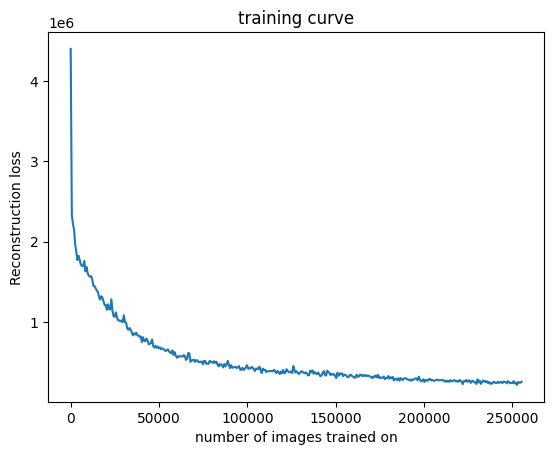

In [303]:
plt.plot(np.arange(len(cVAElosses)) * batch_size * update_interval, cVAElosses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.savefig("Training_Curve.png")
plt.show()

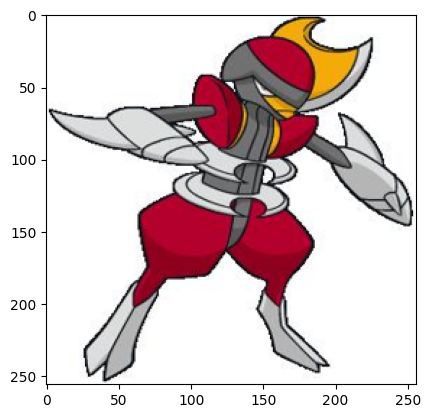

(256, 256, 3)


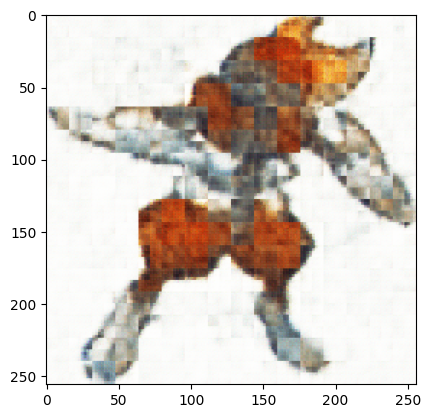

In [308]:
cVAE_output, mu, sigma , _= trained_cVAE(sample_img['pokemon'])
pkmn_batch = np.random.randint(0,63)

plt.imshow(sample_img['pokemon'][pkmn_batch].permute(1,2,0).detach().numpy())
plt.show()
gen = cVAE_output[pkmn_batch].permute(1,2,0).detach().numpy()

plt.imshow(gen)
print(cVAE_output[pkmn_batch].permute(1,2,0).detach().numpy().shape)
plt.show()
# grid = utils.make_grid(cVAE_output)
# plt.imshow(grid.numpy().transpose((1, 2, 0)))
# plt.show()

In [34]:
moment_size = 638
trained_cVAE = CVAE(img_dim, moment_size)

In [493]:
torch.save(trained_cVAE.state_dict(), "cvae_model.pth")

In [35]:
trained_cVAE.load_state_dict(torch.load("cvae_model.pth"))

<All keys matched successfully>

(256, 256, 3)


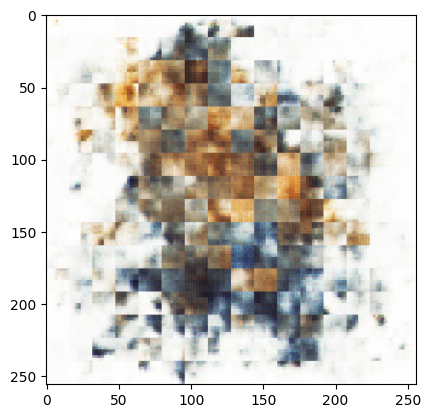

In [748]:
type = "dragon"

latent_mean = type_means[type]

# rand = np.random.uniform(type_min_stds[type].detach().numpy(), type_max_stds[type].detach().numpy())

# print(rand.shape)
latent_std = torch.zeros_like(type_max_stds[type])
for i in range(type_min_stds[type].shape[1]):
    rand = np.random.uniform(type_min_stds[type].detach().numpy()[0,i], type_max_stds[type].detach().numpy()[0,i])*350
    latent_std[0,i] = rand

latent_space = torch.distributions.Normal(latent_mean, latent_std)

z = latent_space.rsample()

decode_out = trained_cVAE.decoder(z)
plt.imshow(decode_out[0].permute(1,2,0).detach().numpy())
print(decode_out[0].permute(1,2,0).detach().numpy().shape)
plt.show()

In [527]:
plt.imshow(decode_out[0].permute(1,2,0).detach().numpy())
plt.savefig(f"outputs/straight_noise/test2_{type}")